Use EvoAug to generate OOD mutated sequences given a reference sequence (DeepSTARR).

Mutations:
- random shuffle: apply `tf.random.shuffle(seqs)` to seqs
- mutagenesis: apply `RandomMutation(mutate_frac=0.25)` to seqs
- evoaug: apply list of augmentations with `max_augs_per_seq=2` to seqs

For each reference sequence from the DeepSTARR test set, we will generate 5 OOD sequences.

OOD sequences will be saved as (5,N,L,4) numpy arrays in an h5 file, where N is the number of DeepSTARR test seqs and L is 249 (DeepSTARR input sequence length). 

In [9]:
import tensorflow as tf
# import tensorflow.keras as keras
import evoaug_tf
from evoaug_tf import evoaug, augment 
import keras
from keras.models import load_model
import numpy as np
import sys
import yaml
import h5py
import gc 
sys.path.append('../code')
from utils import load_DeepSTARR_data
from model_zoo import DeepSTARR
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [10]:
# # set seeds
# tf.random.set_seed(1)
# np.random.seed(1)

# Functions

In [11]:
@tf.function
def apply_augment(x, augment_list, hard_aug=True, max_augs_per_seq=2):

    if len(x.shape)==2:
        x = tf.reshape(x, (1, x.shape[0], x.shape[1]))
    """Apply augmentations to each sequence in batch, x."""
    # number of augmentations per sequence
    if hard_aug:
        batch_num_aug = tf.constant(max_augs_per_seq, dtype=tf.int32)
    else:
        batch_num_aug = tf.random.uniform(shape=[], minval=1, maxval=max_augs_per_seq+1, dtype=tf.int32)

    max_num_aug = len(augment_list)
    insert_max = _augment_max_len(augment_list)

    # randomly choose which subset of augmentations from augment_list
    aug_indices = tf.sort(tf.random.shuffle(tf.range(max_num_aug))[:batch_num_aug])
    # apply augmentation combination to sequences
    insert_status = True
    ind = 0
    for augment in augment_list:
        augment_condition = tf.reduce_any(tf.equal(tf.constant(ind), aug_indices))
        x = tf.cond(augment_condition, lambda: augment(x), lambda: x)
        if augment_condition and hasattr(augment, 'insert_max'):
            insert_status = False
        ind += 1
    if insert_status:
        if insert_max:
            x = _pad_end(x, insert_max)
    return x

@tf.function
def _pad_end(x, insert_max):
        """Add random DNA padding of length insert_max to the end of each sequence in batch."""

        N = tf.shape(x)[0]
        L = tf.shape(x)[1]
        A = tf.cast(tf.shape(x)[2], dtype = tf.float32)
        p = tf.ones((A,)) / A
        padding = tf.transpose(tf.gather(tf.eye(A), tf.random.categorical(tf.math.log([p] * insert_max), N)), perm=[1,0,2])

        half = int(insert_max/2)
        x_padded = tf.concat([padding[:,:half,:], x, padding[:,half:,:]], axis=1)
        return x_padded
    
def _augment_max_len(augment_list):
    """
    Determine whether insertions are applied to determine the insert_max,
    which will be applied to pad other sequences with random DNA.
    Parameters
    ----------
    augment_list : list
        List of augmentations.
    Returns
    -------
    int
        Value for insert max.
    """
    insert_max = 0
    for augment in augment_list:
        if hasattr(augment, 'insert_max'):
            insert_max = augment.insert_max
    return insert_max

def shuffle_channels(tensor):
    # Get the shape of the input tensor
    N, L, C = tf.shape(tensor)[0], tf.shape(tensor)[1], tf.shape(tensor)[2]
    
    # Create indices for shuffling
    indices = tf.range(C)
    
    # Tile and reshape indices to match the shape of the input tensor
    tiled_indices = tf.tile(tf.expand_dims(indices, 0), [N * L, 1])
    
    # Shuffle the tiled indices
    shuffled_indices = tf.random.shuffle(tiled_indices)
    
    # Reshape the shuffled indices to match the input tensor shape
    shuffled_indices = tf.reshape(shuffled_indices, [N, L, C])
    
    # Use tf.gather with the shuffled indices to reorder the channel axis
    shuffled_tensor = tf.gather(tensor, shuffled_indices, batch_dims=2)
    
    return shuffled_tensor

class RandomShuffle(augment.AugmentBase):
    def __init__(self):
        pass

    def __call__(self, x):
        N = tf.shape(x)[0]
        x_mut = tf.TensorArray(dtype=x.dtype, size=N, element_shape=x[0].shape)
        body = lambda i, x_mut: (i + 1, x_mut.write(i, tf.random.shuffle(x[i])))
        cond = lambda i, x_mut: i < N
        _, x_mut = tf.while_loop(cond, body, [0, x_mut])
        return x_mut.stack()

# Load data

In [12]:
data = '../data/DeepSTARR_ensemble_NEW/all_data_with_ensemble_metrics_hierarchical.h5'
X_train, y_train, X_test, y_test, X_val, y_val = load_DeepSTARR_data(data, std=True)

loading data from h5 file with hierarchical structure


In [5]:
# cast as tensor 
X_test_tf = tf.cast(X_test, tf.float32)

2024-09-17 12:13:22.962258: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-17 12:13:23.465207: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14233 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:41:00.0, compute capability: 8.6


# Apply random shuffle (large shift)

In [6]:
augment_list = [RandomShuffle()]
configfile = '../results/DeepSTARR_ensemble_NEW/config.yaml'
config  = yaml.safe_load(open(configfile, 'r'))
model = evoaug.RobustModel(DeepSTARR, config=config, input_shape=X_test[0].shape, augment_list=augment_list, max_augs_per_seq=1, hard_aug=True)
model.compile(keras.optimizers.Adam(learning_rate=0.001), loss='mse') 

# Create a dataset
dataset = tf.data.Dataset.from_tensor_slices(X_test_tf)

# Batch the dataset
batch_size = 1024
batched_dataset = dataset.batch(batch_size)

# # Iterate over batches
# X_test_random_list = []
# for i in range(5):
#     x_mut_list = []
#     for batch in batched_dataset:
#         x_mut = model._apply_augment(batch)
#         x_mut_list.append(x_mut)
#     X_test_random_list.append(tf.concat(x_mut_list, axis=0))

# X_test_random = tf.stack(X_test_random_list).numpy()

# Iterate over batches
x_mut_list = []
for batch in batched_dataset:
    x_mut = model._apply_augment(batch)
    x_mut_list.append(x_mut)

# X_test_random = tf.stack(x_mut_list).numpy()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2024-09-17 12:13:24.526715: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_7
2024-09-17 12:13:28.526067: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_7


In [7]:
X_test_random = tf.concat(x_mut_list, axis=0)

In [57]:
X_test_random

<tf.Tensor: shape=(41186, 249, 4), dtype=float32, numpy=
array([[[0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.],
        ...,
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.]],

       [[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.],
        ...,
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.]],

       [[1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.],
        ...,
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.]],

       ...,

       [[1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        ...,
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.]],

       [[0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        ...,
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.]],

       [[0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.

# Apply mutagenesis (small shift)

`mutate_frac=0.05`

In [8]:
mutagenesis = augment.RandomMutation(mutate_frac=0.05)

In [9]:
# X_test_mutagenesis = np.stack([mutagenesis(X_test_tf).numpy() for _ in range(5)])
X_test_mutagenesis = mutagenesis(X_test_tf).numpy()

In [10]:
X_test_mutagenesis.shape

(41186, 249, 4)

# Apply EvoAug (moderate shift)

Arguments:
- `hard_aug=True`
- `max_augs_per_seq=2`

In [11]:
# # NEW list
# augment_list = [
#     # augment.RandomRC(rc_prob=0.5),
#     augment.RandomDeletion(delete_min=0, delete_max=30),
#     augment.RandomTranslocation(shift_min=0, shift_max=20),
#     augment.RandomNoise(noise_mean=0, noise_std=0.3),
#     augment.RandomMutation(mutate_frac=0.05)
# ]

# original list
augment_list = [
    augment.RandomDeletion(delete_min=0, delete_max=20),
    augment.RandomTranslocation(shift_min=0, shift_max=20),
    augment.RandomNoise(noise_mean=0, noise_std=0.2),
    augment.RandomMutation(mutate_frac=0.05)
]


# X_test_evoaug = np.stack([tf.map_fn(lambda x: apply_augment(x, augment_list), X_test_tf).numpy()[:,0,:,:] for _ in range(5)])

In [12]:
configfile = '../results/DeepSTARR_ensemble_NEW/config.yaml'
config  = yaml.safe_load(open(configfile, 'r'))
model = evoaug.RobustModel(DeepSTARR, config=config, input_shape=X_test[0].shape, augment_list=augment_list, max_augs_per_seq=2, hard_aug=True)
model.compile(keras.optimizers.Adam(learning_rate=0.001), loss='mse') 

# Create a dataset
dataset = tf.data.Dataset.from_tensor_slices(X_test_tf)

# Batch the dataset
batch_size = 1024
batched_dataset = dataset.batch(batch_size)



In [13]:
# # Iterate over batches
# X_test_evoaug_list = []
# for i in range(5):
#     x_mut_list = []
#     for batch in batched_dataset:
#         x_mut = model._apply_augment(batch)
#         x_mut_list.append(x_mut)
#     X_test_evoaug_list.append(tf.concat(x_mut_list, axis=0))

# X_test_evoaug = tf.stack(X_test_evoaug_list).numpy()

# Iterate over batches

x_mut_list = []
for batch in batched_dataset:
    x_mut = model._apply_augment(batch)
    x_mut_list.append(x_mut)

X_test_evoaug = tf.concat(x_mut_list, axis=0)

In [14]:
X_test_evoaug.shape

TensorShape([41186, 249, 4])

# Save data to h5

In [23]:
hf = h5py.File('../data/DeepSTARR/ood_seqs_NEW.h5', 'w')

hf.create_dataset('random', data=X_test_random)
hf.create_dataset('mutagenesis', data=X_test_mutagenesis)
hf.create_dataset('evoaug', data=X_test_evoaug)

hf.close()


# Load seqs from h5

In [13]:
ood_seqs_file = '../data/DeepSTARR/ood_seqs_NEW.h5'
data = h5py.File(ood_seqs_file, 'r')

X_test_random = np.array(data['random'])
X_test_mutagenesis = np.array(data['mutagenesis'])
X_test_evoaug = np.array(data['evoaug'])
data.close()


# Predict with distilled DeepSTARR models

In [14]:
distilled_model_files = [f'../results/DeepSTARR_ensemble_NEW/distilled_with_std/{ix}_DeepSTARR.h5' for ix in range(1,11)]

In [15]:
print(distilled_model_files[0])
test_mod = load_model(distilled_model_files[0])

../results/DeepSTARR_ensemble_NEW/distilled_with_std/1_DeepSTARR.h5


In [16]:
# predict on original seqs 
genomic_preds = test_mod.predict(X_test)

2024-09-19 15:58:20.967838: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100


  62/1288 [>.............................] - ETA: 3s

2024-09-19 15:58:22.409169: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1288/1288 [==============================] - 5s 2ms/step


In [17]:
# predict on small shift
mut_preds = test_mod.predict(X_test_mutagenesis)

1288/1288 [==============================] - 3s 2ms/step


In [18]:
# predict on moderate shift
evoaug_preds = test_mod.predict(X_test_evoaug)

1288/1288 [==============================] - 3s 2ms/step


In [19]:
# predict on large shift
shuffle_preds = test_mod.predict(X_test_random)

1288/1288 [==============================] - 3s 2ms/step


# Plot distribution (for preds on Dev activity head)

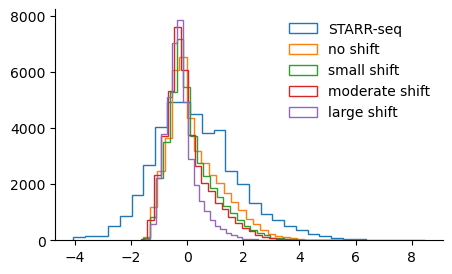

In [20]:
num_bins = 30

fig = plt.figure(figsize=(5,3))
plt.hist(y_test[:,0], histtype='step', bins=num_bins)
plt.hist(genomic_preds[:,0], histtype='step', bins=num_bins)
plt.hist(mut_preds[:,0], histtype='step', bins=num_bins)
plt.hist(evoaug_preds[:,0], histtype='step', bins=num_bins)
plt.hist(shuffle_preds[:,0], histtype='step', bins=num_bins)
plt.legend(['STARR-seq', 'no shift', 'small shift', 'moderate shift', 'large shift'], frameon=False)

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)



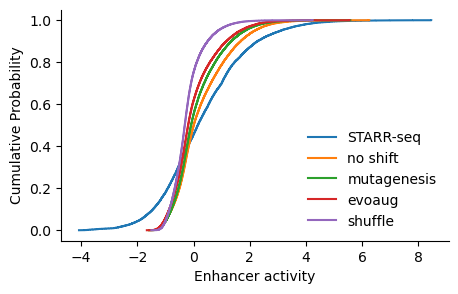

In [21]:
def cumulative_distribution(data, num_bins):
    counts, bin_edges = np.histogram(data, bins=num_bins)
    cdf = np.cumsum(counts)
    cdf = cdf / cdf[-1]  # Normalize
    return bin_edges[:-1], cdf


num_bins = 1000
fig = plt.figure(figsize=(5,3))
plt.plot(*cumulative_distribution(y_test[:,0], num_bins), drawstyle='steps-post')
plt.plot(*cumulative_distribution(genomic_preds[:,0], num_bins), drawstyle='steps-post')
plt.plot(*cumulative_distribution(mut_preds[:,0], num_bins), drawstyle='steps-post')
plt.plot(*cumulative_distribution(evoaug_preds[:,0], num_bins), drawstyle='steps-post')
plt.plot(*cumulative_distribution(shuffle_preds[:,0], num_bins), drawstyle='steps-post')

# plt.legend(['experiment', 'genomic', 'small shift', 'moderate shift', 'large shift'], frameon=False)
plt.legend(['STARR-seq', 'no shift', 'mutagenesis', 'evoaug', 'shuffle'], frameon=False)
plt.xlabel('Enhancer activity')
plt.ylabel('Cumulative Probability')
#plt.title('Cumulative Distribution Plot')
plt.axis('tight')
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#plt.grid(True, linestyle='--', alpha=0.7)


# Save preds on shifted seqs as pickle file for plotting

In [22]:
deepstarr_ood_preds = {}
deepstarr_ood_preds['experimental'] = y_test
deepstarr_ood_preds['no_shift'] = genomic_preds
deepstarr_ood_preds['mutagenesis'] = mut_preds
deepstarr_ood_preds['evoaug'] = evoaug_preds
deepstarr_ood_preds['shuffle'] = shuffle_preds 

# Save the dictionary to a pickle file
with open('../figures/deepstarr_ood_preds.pickle', 'wb') as file:
    pickle.dump(deepstarr_ood_preds, file)
    

# Calculate MSE relative to ensemble

In [80]:
ensemble_files = [f'../results/DeepSTARR_ensemble_NEW/{ix}_DeepSTARR.h5' for ix in range(1,11)]

ensemble_avg_dict = {}
seqs_dict = {'no_shift': X_test,
             'mutagenesis': X_test_mutagenesis,
             'evoaug': X_test_evoaug,
             'shuffle': X_test_random}
for jx, aug in enumerate(['no_shift', 'mutagenesis', 'evoaug', 'shuffle']):
    ensemble_sum = 0
    for ix, file in enumerate(ensemble_files):
        print(f'model ix: {ix+1}')
        # clear history
        keras.backend.clear_session()
        gc.collect()
        model = load_model(file)
        
        # predict
        preds = model.predict(seqs_dict[aug])
        ensemble_sum += preds
    ensemble_avg_dict[aug] = ensemble_sum/10

model ix: 1
1288/1288 [==============================] - 3s 2ms/step
model ix: 2
1288/1288 [==============================] - 3s 2ms/step
model ix: 3
1288/1288 [==============================] - 3s 2ms/step
model ix: 4
1288/1288 [==============================] - 3s 2ms/step
model ix: 5
1288/1288 [==============================] - 3s 2ms/step
model ix: 6
1288/1288 [==============================] - 3s 2ms/step
model ix: 7
1288/1288 [==============================] - 3s 2ms/step
model ix: 8
1288/1288 [==============================] - 3s 2ms/step
model ix: 9
1288/1288 [==============================] - 3s 2ms/step
model ix: 10
1288/1288 [==============================] - 3s 2ms/step
model ix: 1
1288/1288 [==============================] - 3s 2ms/step
model ix: 2
1288/1288 [==============================] - 3s 2ms/step
model ix: 3
1288/1288 [==============================] - 3s 2ms/step
model ix: 4
1288/1288 [==============================] - 3s 2ms/step
model ix: 5
1288/1288 [==========

In [84]:
from sklearn.metrics import mean_squared_error

mse_dict = {}
for k,v in ensemble_avg_dict.items():
    mse_dict[k] = mean_squared_error(v[:,0], deepstarr_ood_preds[k][:,0])

In [85]:
mse_dict

{'no_shift': 0.05372095,
 'mutagenesis': 0.04982339,
 'evoaug': 0.054571133,
 'shuffle': 0.030691454}